In [57]:
import pickle
with open('../a.pkl', 'rb') as f:
    sequence = pickle.load(f)


In [54]:
imBatchSmall.shape

(4, 3, 120, 160)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 120, 160, 8, 16)
(3, 30, 40, 8, 16)


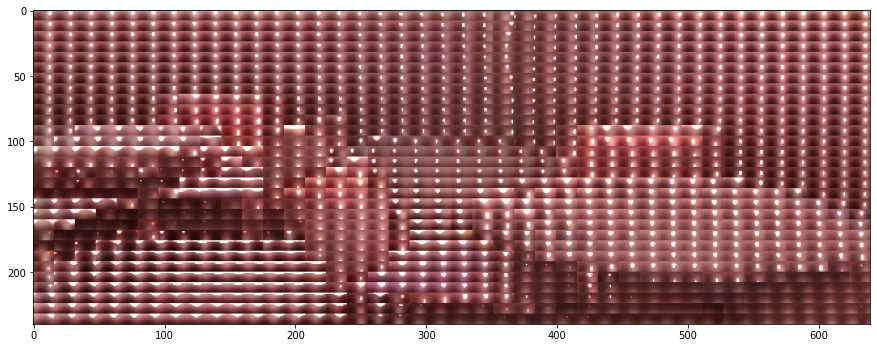

In [60]:
sequence.keys()
envmapsPredScaledImage = sequence['envmapsPredScaledImage']
envmapsBatch = sequence['envmapsBatch']
renderedImPred = sequence['renderedImPred']
imBatchSmall = sequence['imBatchSmall']

a = envmapsPredScaledImage[0]
print(a.shape)

H_grid, W_grid, h, w = a.shape[1:]
downsize_ratio = 4
assert H_grid % downsize_ratio == 0
assert W_grid % downsize_ratio == 0
xx, yy = np.meshgrid(np.arange(0, H_grid, downsize_ratio), np.arange(0, W_grid, downsize_ratio))
a = a[:, xx.T, yy.T, :, :]
print(a.shape)
b = a.transpose(1, 3, 2, 4, 0).reshape(H_grid*h//downsize_ratio, W_grid*w//downsize_ratio, 3)


import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
plt.imshow(b)
plt.show()

In [47]:
np.amin(b), np.amax(b)

(0.021105565, 31.765093)

In [40]:
xx.shape

(160, 120)

In [29]:
import numpy as np
x, y = np.meshgrid(np.arange(10)*2, np.arange(10))
a[:, x, y, :, :].shape

(3, 10, 10, 8, 16)

In [56]:
import cv2
cv2.imwrite('b.hdr', b[:, :, [2, 1, 0]])


True

# GT lighting

In [403]:
%reload_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os.path as osp
import numpy as np
import cv2
from skimage.measure import block_reduce 

envHeight = 8
envWidth = 16
envRow = 120
envCol = 160
SGNum = 12

def loadEnvmap(envName ):
    print('>>>>loadEnvmap', envName)
    if not osp.isfile(envName ):
        env = np.zeros( [3, envRow, envCol,
            envHeight, envWidth], dtype = np.float32 )
        envInd = np.zeros([1, 1, 1], dtype=np.float32 )
        print('Warning: the envmap %s does not exist.' % envName )
        return env, envInd
    else:
        envHeightOrig, envWidthOrig = 16, 32
        assert( (envHeightOrig / envHeight) == (envWidthOrig / envWidth) )
        assert( envHeightOrig % envHeight == 0)

        env = cv2.imread(envName, -1 ) 
        print(env.shape)

        if not env is None:
            env = env.reshape(envRow, envHeightOrig, envCol,
                envWidthOrig, 3) # (1920, 5120, 3) -> (120, 16, 160, 32, 3)
            env = np.ascontiguousarray(env.transpose([4, 0, 2, 1, 3] ) ) # -> (3, 120, 160, 16, 32)

            scale = envHeightOrig / envHeight
            if scale > 1:
                env = block_reduce(env, block_size = (1, 1, 1, 2, 2), func = np.mean )

            envInd = np.ones([1, 1, 1], dtype=np.float32 )
            return env, envInd
        else:
            env = np.zeros( [3, envRow, envCol,
                envHeight, envWidth], dtype = np.float32 )
            envInd = np.zeros([1, 1, 1], dtype=np.float32 )
            print('Warning: the envmap %s does not exist.' % envName )
            return env, envInd

from pathlib import Path
meta_split, scene_name, png_file_name = ('mainDiffMat_xml1', 'scene0385_01', 'im_9.png')

root_path = Path('/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/DatasetCreation/')
env_path = root_path / meta_split / scene_name / (png_file_name.replace('im_', 'imenv_').replace('.png', '.hdr'))

# change to direct lighting; comment 3 lines to use original envmap lighting
# env_path = str(env_path).replace('imenv', 'imenvDirect')
# envRow = 120 // 4
# envCol = 160 // 4

envmaps, envmapsInd = loadEnvmap(str(env_path))


>>>>loadEnvmap /newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/DatasetCreation/mainDiffMat_xml1/scene0385_01/imenv_9.hdr
(1920, 5120, 3)


In [404]:
H_grid, W_grid, h, w = envmaps.shape[1:]
downsize_ratio = 10
assert H_grid % downsize_ratio == 0
assert W_grid % downsize_ratio == 0
xx, yy = np.meshgrid(np.arange(0, H_grid, downsize_ratio), np.arange(0, W_grid, downsize_ratio))
a = envmaps[:, xx.T, yy.T, :, :] * 0.1
a = np.clip(a**(1.0/2.2), 0., 1.)


print(a.shape)
b = a.transpose(1, 3, 2, 4, 0).reshape(H_grid*h//downsize_ratio, W_grid*w//downsize_ratio, 3)


import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
plt.imshow(b)
plt.show()

(3, 12, 16, 8, 16)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …


# rendering layer

In [405]:
import numpy as np
from PIL import Image

im_width = 320
im_height = 240
bn = 1

def loadImage(imName, isGama = False):
    if not(osp.isfile(imName ) ):
#         self.logger.warning('File does not exist: ' + imName )
        assert(False )

    im = Image.open(imName)
    im = im.resize([im_width, im_height], Image.ANTIALIAS )

    im = np.asarray(im, dtype=np.float32)
    if isGama:
        im = (im / 255.0) ** 2.2
        im = 2 * im - 1
    else:
        im = (im - 127.5) / 127.5
    if len(im.shape) == 2:
        im = im[:, np.newaxis]
    im = np.transpose(im, [2, 0, 1] )

    return im

def loadHdr(imName):
    if not(osp.isfile(imName ) ):
#         print(imName )
        assert(False )
    im = cv2.imread(imName, -1)
    # print(imName, im.shape, im.dtype)

    if im is None:
        print(imName )
        assert(False )
    im = cv2.resize(im, (im_width, im_height), interpolation = cv2.INTER_AREA )
    im = np.transpose(im, [2, 0, 1])
    im = im[::-1, :, :]
    return im.transpose(1, 2, 0)

import struct
def loadBinary(imName, channels = 1, dtype=np.float32, if_resize=True):
    assert dtype in [np.float32, np.int32], 'Invalid binary type outside (np.float32, np.int32)!'
    if not(osp.isfile(imName ) ):
        assert(False ), '%s doesnt exist!'%imName
    with open(imName, 'rb') as fIn:
        hBuffer = fIn.read(4)
        height = struct.unpack('i', hBuffer)[0]
        wBuffer = fIn.read(4)
        width = struct.unpack('i', wBuffer)[0]
        dBuffer = fIn.read(4 * channels * width * height )
        if dtype == np.float32:
            decode_char = 'f'
        elif dtype == np.int32:
            decode_char = 'i'
        depth = np.asarray(struct.unpack(decode_char * channels * height * width, dBuffer), dtype=dtype)
        depth = depth.reshape([height, width, channels] )
        if if_resize:
            # print(self.im_width, self.im_height, width, height)
            if dtype == np.float32:
                depth = cv2.resize(depth, (im_width, im_height), interpolation=cv2.INTER_AREA )
            elif dtype == np.int32:
                depth = cv2.resize(depth.astype(np.float32), (im_width, im_height), interpolation=cv2.INTER_NEAREST)
                depth = depth.astype(np.int32)

        depth = np.squeeze(depth)

    return depth[np.newaxis, :, :]

import sys
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/train')
import torch
from models_def.models_light import renderingLayer

# ===== adapted from forward_light(self, input_dict, return_dict_brdf)

root_path = Path('/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/DatasetCreation/')
env_path = root_path / meta_split / scene_name / (png_file_name.replace('im_', 'imenv_').replace('.png', '.hdr'))
# envmaps, envmapsInd = loadEnvmap(str(env_path)) # too long to load from hard disk
envmapsPredImage = torch.from_numpy(envmaps).cuda().unsqueeze(0)

albedo_path = root_path / meta_split / scene_name / (png_file_name.replace('im_', 'imbaseColor_'))
albedo = loadImage(str(albedo_path), isGama = False)
albedo = (0.5 * (albedo + 1) ) ** 2.2

albedoPred = torch.from_numpy(albedo).cuda().unsqueeze(0)

normal_path = root_path / meta_split / scene_name / (png_file_name.replace('im_', 'imnormal_').replace('DiffLight', ''))
# normalize the normal vector so that it will be unit length
normal = loadImage(str(normal_path) )
normal = normal / np.sqrt(np.maximum(np.sum(normal * normal, axis=0), 1e-5) )[np.newaxis, :]
normalPred = torch.from_numpy(normal).cuda().unsqueeze(0)

rough_path = root_path / meta_split / scene_name / (png_file_name.replace('im_', 'imroughness_'))
# Read roughness
rough = loadImage(str(rough_path) )[0:1, :, :]
roughPred = torch.from_numpy(rough).cuda().unsqueeze(0)



In [407]:
rL = renderingLayer(imWidth = envCol, imHeight = envRow)
diffusePred, specularPred = rL.forwardEnv(diffusePred=albedoPred.detach(), normalPred=normalPred, roughPred=roughPred, envmap=envmapsPredImage )
scale = 0.5
renderedImPred = torch.clamp(diffusePred * scale + specularPred * scale, 0, 1)
rendered_im = renderedImPred.cpu().squeeze().permute(1, 2, 0)

import matplotlib.pyplot as plt
hdr_path = root_path / meta_split / scene_name / (png_file_name.replace('.png', '.hdr'))
im = loadHdr(str(hdr_path))

fig = plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.imshow(np.clip(im * scale, 0., 1.))
plt.subplot(122)
plt.imshow(rendered_im)
fig.suptitle('(left) hdr original; (right) re-rendered in hdr')

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## play with the rendering module

In [6]:
print(rL.ls.shape) # hemisphere dir vector for each pixel in envmap (local coords) (8x16)
print(rL.envWeight.shape) # solid angle weight for each pixel (8x16)
print(rL.v.shape) # virtual camera plane 3D coords (x-y-z with -z forward)

torch.Size([128, 3])
torch.Size([1, 128, 1, 1, 1])
torch.Size([1, 3, 120, 160])


In [7]:
depth_path = str(root_path / meta_split / scene_name / (png_file_name.replace('im_', 'imdepth_').replace('png', 'dat'))).replace('DiffLight', '').replace('DiffMat', '')
# Read depth
depth = loadBinary(depth_path).squeeze()

f = 577.8708 / 2.
u0 = im_width / 2.
v0 = im_height / 2.

uu, vv = np.meshgrid(range(im_width), range(im_height))
z = -depth
x = - (uu - u0) / f * z
y = (vv - v0) / f * z
points = np.stack([x.squeeze(), y.squeeze(), z.squeeze()])

In [426]:
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.hist(depth.reshape(-1), 100)
plt.subplot(222)
plt.imshow(depth)
plt.colorbar()
plt.subplot(224)
mask = depth > 0.1
plt.imshow(mask)
plt.subplot(223)
normal_vis = normal.transpose(1, 2, 0)
normal_vis = (normal_vis + 1.)/2.
plt.imshow(normal_vis)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [416]:
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/SimpleLayout')
from SimpleLayout.utils_SL_vis import vis_cube_plt, set_axes_equal, vis_axis, vis_axis_xyz, vis_index_map

%matplotlib widget
fig = plt.figure(figsize=(15, 15))
ax_3d = fig.add_subplot(111, projection='3d')
ax_3d = fig.gca(projection='3d')
ax_3d.set_proj_type('ortho')
ax_3d.set_aspect("auto")

uu_subsample, vv_subsample = np.meshgrid(np.arange(0, im_width-1, 5), np.arange(0, im_height-1, 5))
points_subsample = points[:, vv_subsample, uu_subsample].reshape(3, -1)
# colors = points_subsample[2, :]
# colors[colors>-1.]=-1.
im_resized = cv2.resize(im, (envCol, envRow), interpolation=cv2.INTER_AREA )
im_resized = np.clip(im_resized**(1.0/2.2)/2., 0., 1.)

lightnet_downsample_ratio = im_height//im_resized.shape[0]
assert lightnet_downsample_ratio == im_width//im_resized.shape[1]

colors = im_resized[vv_subsample//lightnet_downsample_ratio, uu_subsample//lightnet_downsample_ratio, :].reshape(-1, 3)
valid_points = points_subsample[2, :] < -1.5
p = ax_3d.scatter(points_subsample[2, valid_points], points_subsample[0, valid_points], points_subsample[1, valid_points], s=12., c=colors[valid_points], cmap='jet')
# plt.colorbar(p)

vis_axis(ax_3d, make_bold=[2], tags=[r'$Z_w$', r'$X_w$', r'$Y_w$'])
# ax_3d.view_init(elev=143, azim=-63)
ax_3d.set_box_aspect([1,1,1])
xyz_min = np.amin(points_subsample, 1)
xyz_max = np.amax(points_subsample, 1)
origin = np.array([0, 0, 0])
xyz_min = np.minimum(xyz_min, origin.reshape((3,)))
xyz_max = np.maximum(xyz_max, origin.reshape((3,))+1.)

new_limits = np.hstack([xyz_min.reshape((3, 1)), xyz_max.reshape((3, 1))])
set_axes_equal(ax_3d, limits=new_limits[[2, 0, 1], :]) # IMPORTANT - this is also required
# ax_3d.axes.set_xlim3d(left=new_limits[2][0], right=new_limits[2][1])
# ax_3d.axes.set_ylim3d(bottom=new_limits[0][0], top=new_limits[0][1]) 
# ax_3d.axes.set_zlim3d(bottom=new_limits[1][0], top=new_limits[1][1])

# set_axes_equal(ax_3d) # IMPORTANT - this is also required


ax_3d.view_init(elev=20, azim=10)
# ax_3d.view_init(elev=50, azim=0)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## [batch] dest as pixel coords; target as one cell center

In [427]:
from SimpleLayout.utils_SL_vis import Arrow3D
wall_idx, i, j = 2, 0, 0
cell_idx = wall_idx * grid_size**2 + i * grid_size + j
p_t_all = verts_center_transformed_LightNet.view(-1, 3).unsqueeze(0) # torch.Size([B(1), #grids, 3])
p_t_all = p_t_all.unsqueeze(2).unsqueeze(3) # torch.Size([B(1), #grids, 1, 1, 3])
p_t = p_t_all[:, cell_idx, :, :, :].squeeze().cpu().numpy()


lightnet_downsample_ratio = im_height//im_resized.shape[0]
assert lightnet_downsample_ratio == im_width//im_resized.shape[1]
envmapWidth = envCol
envmapHeight = envRow
vv, uu = torch.meshgrid(torch.arange(envmapHeight), torch.arange(envmapWidth))
uu, vv = uu.cuda(), vv.cuda()
points_torch = torch.from_numpy(points).cuda().float().unsqueeze(0) # (1, 3, 240, 320)
points_sampled = points_torch[:, :, vv*lightnet_downsample_ratio, uu*lightnet_downsample_ratio].permute(0, 2, 3, 1) # [B(1), 120, 160, 3]
points_sampled_one = points_sampled.cpu().numpy().squeeze()

for i in np.arange(0, 120, 40):
    for j in np.arange(0, 160, 40):
        u_ = j * 2
        v_ = i * 2
        p_ = points_sampled_one[i, j, :].flatten()
        # u_, v_ = 300, 200
        # p_ = points[:, v_, u_]
        ax_3d.scatter(p_[2], p_[0], p_[1], s=20, color='k')
        print(p_)

        rL = renderingLayer()
        ls_coords, camx, camy, normalPred = rL.forwardEnv(normalPred, envmapsPredImage, if_normal_only=True) # torch.Size([1, 128, 3, 120, 160]), [1, 3, 120, 160], [1, 3, 120, 160], [1, 3, 120, 160]
        l_coords = ls_coords[:, :, :, v_//2, u_//2].squeeze()
#         for idx, vec in enumerate(l_coords):
#             if idx % 10 != 0:
#                 continue
#             vec = vec.cpu().numpy()
#             vec = vec / np.linalg.norm(vec) * 0.2
#             a = Arrow3D([p_[2], p_[2]+vec[2]], [p_[0], p_[0]+vec[0]], [p_[1], p_[1]+vec[1]], mutation_scale=20,
#             lw=1, arrowstyle="->", color='k')
#             ax_3d.add_artist(a)

#         u_t, v_t = 300, 150 # light source coords in 2D
#         p_t = points[:, v_t, u_t]
        ax_3d.scatter(p_t[2], p_t[0], p_t[1], s=30, color='g')

        # for a single direction p_(object surface, 3D) -> p_t (light, 3D)
        vec_to_t = torch.from_numpy(p_t - p_).reshape((3, 1)).cuda().float()
        # vec_to_t = l_coords[20]
        camx_, camy_, normalPred_ = camx[:, :, v_//2, u_//2], camy[:, :, v_//2, u_//2], normalPred[:, :, v_//2, u_//2]
        A = torch.vstack([camx_, camy_, normalPred_])
        b = vec_to_t.reshape(3, 1)
        l_local = torch.inverse(A.T) @ b # ldirections (one point on the hemisphere; local)
        l_local = l_local / torch.linalg.norm(l_local, dim=0)

        # l_local -> pixel coords in envmap
        cos_theta = l_local[2]
        theta_SG = torch.arccos(cos_theta) # [0, pi] # el
        cos_phi = l_local[0] / torch.sin(theta_SG)
        sin_phi = l_local[1] / torch.sin(theta_SG)
        phi_SG = torch.atan2(sin_phi, cos_phi) # az
        assert phi_SG >= -np.pi and phi_SG <= np.pi

        az_pix = (phi_SG / np.pi / 2. + 0.5) * rL.envWidth - 0.5
        el_pix = theta_SG / np.pi * 2. * rL.envHeight - 0.5
#         print(az_pix, el_pix)

        # sample envmap
        envmapsPredImage_ = envmapsPredImage[:, :, v_//2, u_//2, :, :].squeeze().unsqueeze(0)
        uv_ = torch.stack([az_pix, el_pix]).reshape((1, 1, 1, 2))
        h, w = envmapsPredImage_.shape[2:4]
        uv_normalized = uv_ / (torch.tensor([w-1, h-1]).reshape(1, 1, 1, 2).cuda().float()) * 2. - 1.
        envmap_ = torch.nn.functional.grid_sample(envmapsPredImage_, uv_normalized, padding_mode='border', align_corners = True) # https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.grid_sample

        envmap_vis_ = torch.clip(envmap_**(1.0/2.2), 0., 1.).flatten()

        # vis
        a = Arrow3D([p_[2], p_t[2]], [p_[0], p_t[0]], [p_[1], p_t[1]], mutation_scale=20,
            lw=1, arrowstyle="Simple", facecolor=envmap_vis_.flatten().cpu().numpy())
        ax_3d.add_artist(a)
#         ax_3d.text3D(p_t[2], p_t[0], p_t[1], '[%d, %d]'%(u_t, v_t))


[-1.0971  0.8229 -1.9813]
[-0.  0. -0.]
[ 0.      1.0976 -2.6427]
[ 0.9278  1.3917 -3.3509]
[-1.2268  0.3067 -2.2154]
[-0.  0. -0.]
[ 0.      0.402  -2.9037]
[ 1.0168  0.5084 -3.6722]
[-1.1385 -0.2846 -2.0559]
[-0.7433 -0.3716 -2.6845]
[ 0.     -0.3659 -2.6427]
[ 0.7637 -0.3818 -2.7581]


## [single sample] dest and target as any pixel points

In [409]:
from SimpleLayout.utils_SL_vis import Arrow3D

u_, v_ = 250, 150
p_ = points[:, v_, u_]
ax_3d.scatter(p_[2], p_[0], p_[1], s=20, color='k')

rL = renderingLayer(imWidth = envCol, imHeight = envRow)
ls_coords, camx, camy, normalPred = rL.forwardEnv(normalPred, envmapsPredImage, if_normal_only=True) # torch.Size([1, 128, 3, 120, 160]), [1, 3, 120, 160], [1, 3, 120, 160], [1, 3, 120, 160]
l_coords = ls_coords[:, :, :, v_//lightnet_downsample_ratio, u_//lightnet_downsample_ratio].squeeze()
for idx, vec in enumerate(l_coords):
    if idx % 10 != 0:
        continue
    vec = vec.cpu().numpy()
    vec = vec / np.linalg.norm(vec) * 0.2
    a = Arrow3D([p_[2], p_[2]+vec[2]], [p_[0], p_[0]+vec[0]], [p_[1], p_[1]+vec[1]], mutation_scale=20,
    lw=1, arrowstyle="->", color='k')
    ax_3d.add_artist(a)

u_t, v_t = 300, 150 # light source coords in 2D
p_t = points[:, v_t, u_t]
ax_3d.scatter(p_t[2], p_t[0], p_t[1], s=30, color='g')

# for a single direction p_(object surface, 3D) -> p_t (light, 3D)
vec_to_t = torch.from_numpy(p_t - p_).reshape((3, 1)).cuda().float()
# vec_to_t = l_coords[20]
camx_, camy_, normalPred_ = camx[:, :, v_//lightnet_downsample_ratio, u_//lightnet_downsample_ratio], \
    camy[:, :, v_//lightnet_downsample_ratio, u_//lightnet_downsample_ratio], normalPred[:, :, v_//lightnet_downsample_ratio, u_//lightnet_downsample_ratio]
A = torch.vstack([camx_, camy_, normalPred_])
b = vec_to_t.reshape(3, 1)
l_local = torch.inverse(A.T) @ b # ldirections (one point on the hemisphere; local)
l_local = l_local / torch.linalg.norm(l_local, dim=0)

# l_local -> pixel coords in envmap
cos_theta = l_local[2]
theta_SG = torch.arccos(cos_theta) # [0, pi] # el
cos_phi = l_local[0] / torch.sin(theta_SG)
sin_phi = l_local[1] / torch.sin(theta_SG)
phi_SG = torch.atan2(sin_phi, cos_phi) # az
assert phi_SG >= -np.pi and phi_SG <= np.pi

az_pix = (phi_SG / np.pi / 2. + 0.5) * rL.envWidth - 0.5
el_pix = theta_SG / np.pi * 2. * rL.envHeight - 0.5
# print(az_pix, el_pix)

# sample envmap
envmapsPredImage_ = envmapsPredImage[:, :, v_//lightnet_downsample_ratio, u_//lightnet_downsample_ratio, :, :].squeeze().unsqueeze(0)
uv_ = torch.stack([az_pix, el_pix]).reshape((1, 1, 1, 2))
# i, j = 7, 12
# uv_ = torch.tensor([j, i]).reshape(1, 1, 1, 2).cuda().float()
h, w = envmapsPredImage_.shape[2:4]
uv_normalized = uv_ / (torch.tensor([w-1, h-1]).reshape(1, 1, 1, 2).cuda().float()) * 2. - 1.
envmap_ = torch.nn.functional.grid_sample(envmapsPredImage_, uv_normalized, padding_mode='border', align_corners = True) # https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.grid_sample

# print(envmap_.flatten(), uv_, uv_normalized)
# envmapsPredImage_vis_ = envmapsPredImage_.cpu().numpy().squeeze().transpose(1, 2, 0)
# print(envmapsPredImage_vis_[i, j])

envmap_vis_ = torch.clip(envmap_**(1.0/2.2), 0., 1.).flatten()

# vis
a = Arrow3D([p_[2], p_t[2]], [p_[0], p_t[0]], [p_[1], p_t[1]], mutation_scale=20,
    lw=1, arrowstyle="Simple", facecolor=envmap_vis_.flatten().cpu().numpy())
ax_3d.add_artist(a)
ax_3d.text3D(p_t[2], p_t[0], p_t[1], '[%d, %d]'%(u_t, v_t))


Text(-3.1300418376922607, 1.5166222528527709, '[300, 150]')

In [401]:
envmapsPredImage_vis_ = envmapsPredImage_.cpu().numpy().squeeze().transpose(1, 2, 0)
envmapsPredImage_vis_sdr = np.clip(envmapsPredImage_vis_**(1.0/2.2), 0., 1.)
uv_np = uv_.cpu().numpy().flatten()

plt.figure(figsize=(5, 3))
plt.imshow(envmapsPredImage_vis_sdr)
plt.scatter(uv_np[0], uv_np[1])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## vis rL.ls (local hemisphere coords)

In [13]:
ls_coords_local = rL.ls.cpu().numpy().reshape(8, 16, 3)

%matplotlib widget
fig = plt.figure(figsize=(5, 5))
ax_3d_local = fig.add_subplot(111, projection='3d')
ax_3d_local = fig.gca(projection='3d')
ax_3d_local.set_proj_type('ortho')
ax_3d_local.set_aspect("auto")
vis_axis(ax_3d_local, make_bold=[2], tags=[r'$Z_w$', r'$X_w$', r'$Y_w$'])

for ls_local in ls_coords_local.reshape(-1, 3):
    a = Arrow3D([0., ls_local[2]], [0., ls_local[0]], [0., ls_local[1]], mutation_scale=20,
        lw=1, arrowstyle="->", color='k')
    ax_3d_local.add_artist(a)

ax_3d_local.set_box_aspect([1,1,1])
set_axes_equal(ax_3d_local, limits=np.array([[-1., 1.], [-1., 1.], [-1., 1.]])) # IMPORTANT - this is also required
ax_3d_local.view_init(elev=-53, azim=0)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# layout_emitter + 3D lighting (mainly transform coords)

In [14]:
# borrowed from Total3D repo -> notebooks/parse_OR_labels-lighting-reindexed%2Bassigned-V4.ipynb

import os
import json

%reload_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import matplotlib.pyplot as plt
%matplotlib widget

# dataset = 'sunrgbd'
dataset = 'OR'

mode = 'val'
# mode = 'train'
# mode = 'train-tmp'

# split_path_dict = {'sunrgbd': 'data/sunrgbd/preprocessed', 'OR': 'utils_OR/openrooms/preprocessed-full'}
split_path_dict = {'sunrgbd': 'data/sunrgbd/preprocessed', 'OR': '/home/ruizhu/Documents/Projects/semanticInverse/train/data/openrooms/list_OR_V4full/list'}

if dataset == 'sunrgbd':
    split_file = os.path.join(split_path_dict[dataset], mode + '.json')
    with open(split_file) as file:
        split = json.load(file)
elif dataset == 'OR':
    split_file = os.path.join(split_path_dict[dataset], mode + '.txt')
    with open(split_file) as f:
        mylist = f.read().splitlines() 
    split = [x.split(' ') for x in mylist]

print(len(split), split[0])

5664 ['scene0509_00', '1', 'mainDiffLight_xml1/scene0509_00/im_1.hdr', 'main_xml1/scene0509_00/imsemLabel_1.npy']


In [15]:
import torch
import numpy as np
from utils.utils_total3D.utils_OR_visualize import format_layout, Box
from utils.utils_total3D.data_config import OR4XCLASSES_dict, NYU40CLASSES
from utils.utils_total3D.utils_others import OR4X_mapping_catInt_to_RGB, OR4X_mapping_catStr_to_RGB
from utils.utils_total3D.utils_OR_vis_labels import read_vis_scene_3d, RGB_to_01
import pickle

OR = 'OR45'
classes = OR4XCLASSES_dict[OR] if dataset == 'OR' else NYU40CLASSES
with open(str(Path('../train/data/openrooms/total3D_colors/') / OR4X_mapping_catInt_to_RGB['light']), 'rb') as f:
    OR_mapping_catInt_to_RGB = pickle.load(f)[OR]
with open(str(Path('../train/data/openrooms/total3D_colors/') / OR4X_mapping_catStr_to_RGB['light']), 'rb') as f:
    OR_mapping_catStr_to_RGB = pickle.load(f)[OR]

import random
image_id = random.randint(0, len(split))
# image_id = 3
pickle_path_ori = split[image_id]

pickle_id = random.randint(0, len(split))
pickle_id = 8
naming = split[pickle_id][2]
# naming = 'main_xml/scene0001_01/im_1.hdr'
# naming = 'main_xml/scene0002_00/im_1.hdr'
# pickle_path_ori = '/data/ruizhu/OR-V3-OR45_total3D_train_test_data/%06d.pkl'%pickle_id
pickle_path_ori = '/data/ruizhu/OR-V4full-OR45_total3D_train_test_data/%s/%s/%s'%(naming.split('/')[0], naming.split('/')[1], naming.split('/')[2].replace('im', 'layout_obj').replace('hdr', 'pkl'))


grid_size = 8

pickle_path = pickle_path_ori.replace('.pkl', '_reindexed.pkl')
pickle_emitters_path = pickle_path_ori.replace('.pkl', '_emitters.pkl')
# pickle_emitters_assign_info_list_path = pickle_path_ori.replace('.pkl', '_emitters_emitters_assign_info_V2.pkl')
pickle_emitters_assign_info_list_path = pickle_path_ori.replace('.pkl', '_emitters_assign_info_%dX%d_V3.pkl'%(grid_size, grid_size))

print(pickle_path)

/data/ruizhu/OR-V4full-OR45_total3D_train_test_data/mainDiffMat_xml1/scene0385_01/layout_obj_9_reindexed.pkl


In [16]:
sequence['camera']['K']

NameError: name 'sequence' is not defined

In [17]:
import pickle
with open(pickle_path, 'rb') as f:
    sequence = pickle.load(f)
print(sequence.keys())
with open(pickle_emitters_path, 'rb') as f:
    sequence_emitters = pickle.load(f)
print(sequence_emitters.keys(), sequence_emitters['sequence_name'], sequence_emitters['withinsequence_id'])
with open(pickle_emitters_assign_info_list_path, 'rb') as f:
    sequence_emitter2wall_assign_info_dict = pickle.load(f)
print(sequence_emitter2wall_assign_info_dict.keys())

%matplotlib widget

gt_boxes_list = [format_layout(x) for x in sequence['boxes']['bdb3D']]
for x, class_id in zip(gt_boxes_list, sequence['boxes']['size_cls']):
    x.update({'class_id': class_id})
gt_boxes_dict = {}
for key in list(gt_boxes_list[0].keys()):
    gt_boxes_dict[key] = [x[key] for x in gt_boxes_list]
    
# gt_layout = format_layout(sequence['layout']['bdb3D'])
gt_layout = sequence['layout']['bdb3D']

from utils.utils_total3D.data_config import Dataset_Config
from utils.utils_total3D.utils_OR_layout import to_dict_tensor

from utils.utils_total3D.utils_OR_cam import get_rotation_matrix_gt

OR = 'OR45'
dataset_config = Dataset_Config(dataset, OR=OR, version='V3', paths={'total3D_lists_path': '../train/data/openrooms/list_OR_V4full', 'layout_emitter_path': '/data/ruizhu/OR-V4full-OR45_total3D_train_test_data'})
bins_tensor = to_dict_tensor(dataset_config.bins, if_cuda=False)
cam_R_gt = get_rotation_matrix_gt(bins_tensor,
                                  torch.zeros([1]).long()+sequence['camera']['pitch_cls'], torch.zeros([1])+sequence['camera']['pitch_reg'],
                                  torch.zeros([1]).long()+sequence['camera']['roll_cls'], torch.zeros([1])+sequence['camera']['roll_reg']).squeeze().numpy()

# ======== emitters_list
emitters_obj_list = []
for x in range(sequence_emitters['boxes']['bdb3D'].shape[0]):
#     obj_dict_new = {'obj_box_3d': sequence_emitters['boxes']['bdb3D'][x], \
    obj_dict_new = {'obj_box_3d': sequence_emitters['boxes']['bdb3D_emitter_part'][x], \
                    'emitter_prop': sequence_emitters['boxes']['emitter_prop'][x], \
                    'light_world_total3d_centeraxis': sequence_emitters['boxes']['light_world_total3d_centeraxis'][x], \
                    'bdb3D_emitter_part': sequence_emitters['boxes']['bdb3D_emitter_part'][x], \
                    'cat_id': sequence_emitters['boxes']['size_cls'][x], \
                    'cat_name': classes[sequence_emitters['boxes']['size_cls'][x]], 'cat_color': RGB_to_01(OR_mapping_catInt_to_RGB[sequence_emitters['boxes']['size_cls'][x]])}
    emitters_obj_list.append(obj_dict_new)
emitter2wall_assign_info_list = sequence_emitter2wall_assign_info_dict['emitter2wall_assign_info_list']
cell_info_grid_GT_includeempty = sequence_emitter2wall_assign_info_dict['cell_info_grid']
cell_info_grid_GT = []
for wall_idx in range(6):
    for i in range(grid_size):
        for j in range(grid_size):
            cell_info = cell_info_grid_GT_includeempty[wall_idx * grid_size**2 + i * grid_size + j]
            if cell_info['obj_type'] is not None:
                cell_info['wallidx_i_j'] = (wall_idx, i, j)
                cell_info_grid_GT.append(cell_info)


plt.figure(figsize=(15, 8))
ax_2d = plt.gca()

# grid_prob = sequence_emitter2wall_assign_info_dict['cell_prob_mean'].reshape(6, -1)
grid_prob = sequence_emitter2wall_assign_info_dict['wall_grid_prob'].reshape(6, -1)
import imageio
rgb_img = imageio.imread(sequence['rgb_img_path'])

scene_box = Box(rgb_img, None, sequence['camera']['K'], cam_R_gt, None, gt_layout, None, gt_boxes_dict, None, 'GT', None, dataset=dataset, OR='OR45', \
                emitters_obj_list=emitters_obj_list, emitter2wall_assign_info_list=emitter2wall_assign_info_list, \
                emitter_cls_prob_PRED=np.random.random((6, grid_size**2)), emitter_cls_prob_GT=grid_prob, cell_info_grid_GT=cell_info_grid_GT, grid_size=grid_size, \
                paths={'color_file': '../train/data/openrooms/total3D_colors/OR4X_mapping_catInt_to_RGB_light.pkl'})
if_use_plt=True
img_map, _ = scene_box.draw_projected_layout('GT', return_plt=True, if_save=False, save_path='', if_use_plt=if_use_plt, fig_or_ax=ax_2d)
img_map2 = scene_box.draw_projected_bdb3d('GT', return_plt=True, if_save=False, save_path='', if_use_plt=if_use_plt, fig_or_ax=ax_2d)
# plt.show()

fig_3d, ax_3d = scene_box.draw_3D_scene_plt('GT')
# ax_3d[0].view_init(elev=-46, azim=86)

# %matplotlib widget
# sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/train/SimpleLayout')
# depth_combined, mask_conflict = scene_box.draw_projected_depth('GT', return_plt=True, if_save=False, save_path='', if_vis=True)


dict_keys(['transform_R', 'transform_t', 'rgb_img_path', 'envmap_info', 'depth_map', 'boxes', 'camera', 'layout', 'scene_name', 'withinsequence_id', 'meta_split', 'meta_name', 'sub_name', 'scene_pickle_file', 'cam_pickle_file', 'frame_pickle_file', 'reindex_info_dict'])
dict_keys(['sequence_name', 'withinsequence_id', 'boxes']) scene0385_01 9
dict_keys(['emitter2wall_assign_info_list', 'emitters_obj_list', 'wall_grid_prob', 'cell_prob_mean', 'cell_prob', 'cell_count', 'cell_info_grid'])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[draw_projected_layout] Returned.
 Detected for 32:lamp not in valid_class_ids of dataset: OR
 Detected for 32:lamp not in valid_class_ids of dataset: OR
 Detected for 1:curtain not in valid_class_ids of dataset: OR
[draw_projected_bdb3d] Returned.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

 Detected for 32:lamp not in valid_class_ids of dataset: OR
 Detected for 32:lamp not in valid_class_ids of dataset: OR
 Detected for 1:curtain not in valid_class_ids of dataset: OR


In [169]:
wall_2_coords = gt_layout[[0, 1, 5, 4], :]

extra_transform_matrix = np.array([[0., 0., 1.], [0., -1., 0.], [1., 0., 0.]])
cam_R_transform, cam_t_transform = cam_R_gt.T, np.zeros((3, 1))
x1x2_transformed = (cam_R_transform @ wall_2_coords.T + cam_t_transform).T @ extra_transform_matrix # camera projection coords: z forward, x right, y down

extra_transform_matrix_LightNet = np.array([[1., 0., 0.], [0., -1., 0.], [0., 0., -1.]])

x1x2_transformed_LightNet = x1x2_transformed @ extra_transform_matrix_LightNet # LightNet coords: z backward, x right, y up

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
x1x2_transformed_LightNet

array([[ 0.988 ,  2.5421, -2.9413],
       [-2.4595,  1.7477, -0.8853],
       [-2.4604, -1.0502, -1.9678],
       [ 0.9872, -0.2558, -4.0238]])

In [362]:
im_resized.shape

(30, 40, 3)

In [363]:
im_width

320

In [371]:
points.shape

(3, 240, 320)

In [442]:
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/train/SimpleLayout')
from utils_SL_vis import vis_cube_plt, set_axes_equal, vis_axis, vis_axis_xyz, vis_index_map

%matplotlib widget
fig = plt.figure(figsize=(15, 15))
ax_3d = fig.add_subplot(111, projection='3d')
ax_3d = fig.gca(projection='3d')
ax_3d.set_proj_type('ortho')
ax_3d.set_aspect("auto")

uu_subsample, vv_subsample = np.meshgrid(np.arange(0, im_width-1, 5), np.arange(0, im_height-1, 5))
points_subsample = points[:, vv_subsample, uu_subsample].reshape(3, -1)
# colors = points_subsample[2, :]
# colors[colors>-1.]=-1.
im_resized = cv2.resize(im, (envCol, envRow), interpolation=cv2.INTER_AREA )
im_resized = np.clip(im_resized**(1.0/2.2)/2., 0., 1.)
colors = im_resized[vv_subsample//(im_height//im_resized.shape[0]), uu_subsample//(im_width//im_resized.shape[1]), :].reshape(-1, 3)
valid_points = points_subsample[2, :] < -1.5
p = ax_3d.scatter(points_subsample[2, valid_points], points_subsample[0, valid_points], points_subsample[1, valid_points], s=12., c=colors[valid_points], cmap='jet')

# from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# x1x2_transformed_LightNet_zup = np.hstack([x1x2_transformed_LightNet[:, 2:3], x1x2_transformed_LightNet[:, 0:1],x1x2_transformed_LightNet[:, 1:2]]) # for vis purpose only
# verts = [(x1x2_transformed_LightNet_zup).tolist()]
# poly = Poly3DCollection(verts, facecolor=[1., 0., 0.], edgecolor=[1., 1., 1.])
# poly.set_alpha(0.2)
# ax_3d.add_collection3d(poly)


vis_axis(ax_3d, make_bold=[2], tags=[r'$Z_w$', r'$X_w$', r'$Y_w$'])
# ax_3d.view_init(elev=143, azim=-63)
ax_3d.set_box_aspect([1,1,1])
xyz_min = np.amin(points_subsample, 1)
xyz_max = np.amax(points_subsample, 1)
origin = np.array([0, 0, 0])
xyz_min = np.minimum(xyz_min, origin.reshape((3,)))
xyz_max = np.maximum(xyz_max, origin.reshape((3,))+1.)

new_limits = np.hstack([xyz_min.reshape((3, 1)), xyz_max.reshape((3, 1))])
set_axes_equal(ax_3d, limits=new_limits[[2, 0, 1], :]) # IMPORTANT - this is also required
# ax_3d.axes.set_xlim3d(left=new_limits[2][0], right=new_limits[2][1])
# ax_3d.axes.set_ylim3d(bottom=new_limits[0][0], top=new_limits[0][1]) 
# ax_3d.axes.set_zlim3d(bottom=new_limits[1][0], top=new_limits[1][1])

# set_axes_equal(ax_3d) # IMPORTANT - this is also required


# ax_3d.view_init(elev=57, azim=-22)
# ax_3d.view_init(elev=34, azim=-16)
ax_3d.view_init(elev=20, azim=10)

plt.title('in LightNet coords (and z up)')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0.92, 'in LightNet coords (and z up)')

## ADD vis: sample lights for ONE cell

In [436]:
wall_idx, cell_i, cell_j = 3, 4, 3
cell_idx = wall_idx * grid_size**2 + cell_i * grid_size + cell_j
p_t_one = p_t_all_grids[:, cell_idx, :, :, :].squeeze().cpu().numpy()

envmap_vis_one = envmap_vis_.cpu().numpy()[:, :, cell_idx, :, :].squeeze().transpose(1, 2, 0)
points_sampled_one = points_sampled.cpu().numpy().squeeze()

for i in np.arange(0, envRow, 5):
    for j in np.arange(0, envCol, 5):
        p_one = points_sampled_one[i, j, :].flatten()
        p = ax_3d.scatter(p_one[2], p_one[0], p_one[1], s=20., c='k', cmap='jet')
#         print(p_one)
        
        face_color = envmap_vis_one[i, j, :].flatten().tolist()
#         print(face_color)
        a = Arrow3D([p_one[2], p_t_one[2]], [p_one[0], p_t_one[0]], [p_one[1], p_t_one[1]], mutation_scale=20,
            lw=0.5, arrowstyle="Simple", facecolor=face_color)
        ax_3d.add_artist(a)
#         ax_3d.text3D(p_t[2], p_t[0], p_t[1], '[%d, %d]'%(u_t, v_t))

verts = verts_transformed_LightNet[wall_idx, cell_i, cell_j, :, :].cpu().numpy().squeeze()
verts_zup = np.hstack([verts[:, 2:3], verts[:, 0:1], verts[:, 1:2]])
verts_zup = [(verts_zup).tolist()]

color_array = envmap_vis_mean_.cpu().numpy().squeeze()
# color_array = envmap_vis_max_.cpu().numpy().squeeze()
face_color = color_array[cell_idx]
poly = Poly3DCollection(verts_zup, facecolor=face_color.tolist(), edgecolor=[1., 1., 1.])
#             poly.set_alpha(0.2)
poly.set_alpha(0.8)
ax_3d.add_collection3d(poly)



## parallize envmap sampling

In [430]:
rL = renderingLayer()
ls_coords, camx, camy, normalPred = rL.forwardEnv(normalPred, envmapsPredImage, if_normal_only=True) # torch.Size([B(1), 128, 3, 120, 160]), [B(1), 3, 120, 160], [B(1), 3, 120, 160], [B(1), 3, 120, 160]
envmapWidth = envCol
envmapHeight = envRow
vv, uu = torch.meshgrid(torch.arange(envmapHeight), torch.arange(envmapWidth))
uu, vv = uu.cuda(), vv.cuda()

points_torch = torch.from_numpy(points).cuda().float().unsqueeze(0) # (1, 3, 240, 320)

In [438]:
# p_t = verts_center_transformed_LightNet[0:1, 0:1, 0:1, :].view(1, 3).unsqueeze(0) # torch.Size([B(1), #grids, 3])
p_t_all_grids = verts_center_transformed_LightNet.view(-1, 3).unsqueeze(0) # torch.Size([B(1), #grids, 3])
ngrids = p_t_all_grids.shape[-2]
p_t_all_grids = p_t_all_grids.unsqueeze(2).unsqueeze(3) # torch.Size([B(1), #grids, 1, 1, 3])

lightnet_downsample_ratio = im_height//im_resized.shape[0]
assert lightnet_downsample_ratio == im_width//im_resized.shape[1]

points_sampled = points_torch[:, :, vv*lightnet_downsample_ratio, uu*lightnet_downsample_ratio].permute(0, 2, 3, 1) # [B(1), 120, 160, 3]
points_sampled_mask = points_sampled[:, :, :, -1] < -0.1
points_sampled = points_sampled.unsqueeze(1) # torch.Size([B(1), 1, 120, 160, 3])

vec_to_t = p_t_all_grids - points_sampled # torch.Size([B(1), #grids, 120, 160, 3])
camx_, camy_, normalPred_ = camx[:, :, vv, uu], camy[:, :, vv, uu], normalPred[:, :, vv, uu]
A = torch.cat([camx_.unsqueeze(2), camy_.unsqueeze(2), normalPred_.unsqueeze(2)], 2) # [B(1), 3, 3, 120, 160]
batch_size = A.shape[0]
AT = torch.inverse(A.permute(0, 3, 4, 1, 2).view(-1, 3, 3).unsqueeze(1).expand(batch_size, ngrids, -1, -1, -1, -1)) # [B(1), 3, 3, 120, 160] -> [B(1), 120, 160, 3, 3] -> [B(1), #grids, 120, 160, 3, 3]
AT = AT.view(-1, 3, 3) # -> [?, 3, 3]
b = vec_to_t.reshape(-1, 3).unsqueeze(-1) # [B, #grids, 120, 160, 3] -> [?, 3, 1]
l_local = torch.matmul(AT, b) # ldirections (one point on the hemisphere; local) [?, 3, 1]
l_local = l_local / torch.linalg.norm(l_local, dim=1, keepdim=True) # [?, 3, 1]
l_local = l_local.view(batch_size, ngrids, envmapHeight, envmapWidth, 3, 1) # [B, #grids, 120, 160, 3, 1]

# l_local -> pixel coords in envmap
cos_theta = l_local[:, :, :, :, 2, :]
theta_SG = torch.arccos(cos_theta) # [0, pi] # el
cos_phi = l_local[:, :, :, :, 0, :] / torch.sin(theta_SG)
sin_phi = l_local[:, :, :, :, 1, :] / torch.sin(theta_SG)
phi_SG = torch.atan2(sin_phi, cos_phi) # az
# assert phi_SG >= -np.pi and phi_SG <= np.pi

az_pix = (phi_SG / np.pi / 2. + 0.5) * rL.envWidth - 0.5 # [B, #grids, 120, 160, 1]
el_pix = theta_SG / np.pi * 2. * rL.envHeight - 0.5 # [B, #grids, 120, 160, 1]
az_pix = az_pix.permute(0, 2, 3, 1, 4).view(-1, ngrids, 1) # [B, #grids, 120, 160, 1] -> [B, 120, 160, ngrids, 1] -> [B*120*160, ngrids, 1]
el_pix = el_pix.permute(0, 2, 3, 1, 4).view(-1, ngrids, 1) # [B, #grids, 120, 160, 1] -> [B, 120, 160, ngrids, 1] -> [B*120*160, ngrids, 1]

# sample envmap
envmapsPredImage_ = envmapsPredImage[:, :, vv, uu, :, :].permute(0, 2, 3, 1, 4, 5) # [B, 3, 120, 160, 8, 16] -> [B, 3, 120, 160, 8, 16] -> [B, 120, 160, 3, 8, 16]
envmapsPredImage_ = envmapsPredImage_.view(-1, 3, 1, h, w)
h, w = envmapsPredImage_.shape[-2:]
uv_ = torch.cat([az_pix, el_pix], dim=-1) # [B*120*160, #grids, 2]
uv_normalized = uv_ / (torch.tensor([w-1, h-1]).reshape(1, 1, 2).cuda().float()) * 2. - 1. # [B*120*160, #grids, 2]
uv_normalized = uv_normalized.unsqueeze(2).unsqueeze(2)
uv_normalized = torch.cat([uv_normalized, torch.zeros_like(uv_normalized[:, :, :, :, 0:1])], dim=-1) # -> [B*120*160, #grids, 3]
# print(envmapsPredImage_.shape, uv_normalized.shape)
# essentially sample each 1x8x16 envmap at ngrid points, of B*120*160 envmaps
envmap_ = torch.nn.functional.grid_sample(envmapsPredImage_, uv_normalized, padding_mode='border', align_corners = True) # https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.grid_sample
# print(envmap_.shape)
envmap_ = envmap_.squeeze(-1).squeeze(-1).view(batch_size, envmapHeight, envmapWidth, 3, ngrids) # -> [B, 120, 160, 3, #grids]
# print(envmap_.shape)
envmap_ = envmap_.permute(0, 3, 4, 1, 2) # -> [B, 3, #grids, 120, 160]
points_sampled_mask_expanded = points_sampled_mask.float().unsqueeze(1).unsqueeze(1) # [B, 1, 1, 120, 160]
envmap_ = envmap_ * points_sampled_mask_expanded
envmap_ = envmap_ * 0.1
# envmap_vis_ = torch.clip(envmap_**(1.0/2.2), 0., 1.)
envmap_vis_ = torch.clip(envmap_ * 0.5, 0., 1.) # [B, 3, #grids, 120, 160]

envmap_vis_mean_ = (envmap_vis_.sum(-1).sum(-1) / points_sampled_mask_expanded.sum(-1).sum(-1)).permute(0, 2, 1) # -> [1, 384, 3]
envmap_vis_max_ = envmap_vis_.amax(-1).amax(-1).permute(0, 2, 1) # -> [1, 384, 3]

# vis
# ax_3d.scatter(p_[2], p_[0], p_[1], s=200, color='k')
# a = Arrow3D([p_[2], p_t[2]], [p_[0], p_t[0]], [p_[1], p_t[1]], mutation_scale=20,
#     lw=1, arrowstyle="Simple", facecolor=envmap_vis_.flatten().cpu().numpy())
# ax_3d.add_artist(a)
# ax_3d.text3D(p_t[2], p_t[0], p_t[1], '[%d, %d]'%(u_t, v_t))


## ADD vis: all cell patches (colored by accumulated light)

In [443]:
color_array = envmap_vis_mean_.cpu().numpy().squeeze()
# color_array = envmap_vis_max_.cpu().numpy().squeeze()

print(color_array.shape)

layout = gt_layout

extra_transform_matrix = np.array([[0., 0., 1.], [0., -1., 0.], [1., 0., 0.]])
cam_R_transform, cam_t_transform = cam_R_gt.T, np.zeros((3, 1))
extra_transform_matrix_LightNet = np.array([[1., 0., 0.], [0., -1., 0.], [0., 0., -1.]])

basis_v_indexes = [(3, 2, 0), (7, 6, 4), (4, 5, 0), (6, 2, 5), (7, 6, 3), (7, 3, 4)]
tmp_list = []
for wall_idx in range(6):
#     if wall_idx != 2:
#         continue
    origin_v1_v2 = basis_v_indexes[wall_idx]
    basis_1 = (layout[origin_v1_v2[1]] - layout[origin_v1_v2[0]]) / grid_size
    basis_2 = (layout[origin_v1_v2[2]] - layout[origin_v1_v2[0]]) / grid_size
    origin_0 = layout[origin_v1_v2[0]]

    for i in range(grid_size):
        for j in range(grid_size):
            x_ij = basis_1 * i + basis_2 * j + origin_0
            x_i1j = basis_1 * (i+1) + basis_2 * j + origin_0
            x_i1j1 = basis_1 * (i+1) + basis_2 * (j+1) + origin_0
            x_ij1 = basis_1 * i + basis_2 * (j+1) + origin_0
            verts = [[list(x_ij), list(x_i1j), list(x_i1j1), list(x_ij1)]]
            verts_array = np.asarray(verts).squeeze()
            tmp_list.append(verts_array)

            verts_array_centter = np.mean(verts_array, 0)[:, np.newaxis]
            
            x1x2_transformed = (cam_R_transform @ verts_array.T + cam_t_transform).T @ extra_transform_matrix # camera projection coords: z forward, x right, y down
            extra_transform_matrix_LightNet = np.array([[1., 0., 0.], [0., -1., 0.], [0., 0., -1.]])
            x1x2_transformed_LightNet = x1x2_transformed @ extra_transform_matrix_LightNet # LightNet coords: z backward, x right, y up
            x1x2_transformed_LightNet_zup = np.hstack([x1x2_transformed_LightNet[:, 2:3], x1x2_transformed_LightNet[:, 0:1], x1x2_transformed_LightNet[:, 1:2]]) # for vis purpose only
            
            verts = [(x1x2_transformed_LightNet_zup).tolist()]
            
            cell_idx = wall_idx * grid_size**2 + i * grid_size + j
            face_color = color_array[cell_idx]
#             poly = Poly3DCollection(verts, facecolor=[1., 0., 0.], edgecolor=[1., 1., 1.])
            poly = Poly3DCollection(verts, facecolor=face_color.tolist(), edgecolor=[1., 1., 1.])
#             poly.set_alpha(0.2)
            poly.set_alpha(0.8)
            ax_3d.add_collection3d(poly)



(384, 3)


### parallize acquisition of cell params

In [295]:
# torch

layout_cuda = torch.from_numpy(layout).cuda()
origin_v1_v2_list = [basis_v_indexes[wall_idx] for wall_idx in range(6)]
basis_1_list = [(layout_cuda[origin_v1_v2[1]] - layout_cuda[origin_v1_v2[0]]) / grid_size for origin_v1_v2 in origin_v1_v2_list]
basis_2_list = [(layout_cuda[origin_v1_v2[2]] - layout_cuda[origin_v1_v2[0]]) / grid_size for origin_v1_v2 in origin_v1_v2_list]
origin_0_list = [layout_cuda[origin_v1_v2[0]] for origin_v1_v2 in origin_v1_v2_list]

basis_1_array = torch.stack(basis_1_list).unsqueeze(1).unsqueeze(1).float()
basis_2_array = torch.stack(basis_2_list).unsqueeze(1).unsqueeze(1).float()
origin_0_array = torch.stack(origin_0_list).unsqueeze(1).unsqueeze(1).float()

ii, jj = torch.meshgrid(torch.arange(grid_size), torch.arange(grid_size))
ii, jj = ii.cuda().unsqueeze(0).unsqueeze(-1).float(), jj.cuda().unsqueeze(0).unsqueeze(-1).float()
x_ij = basis_1_array * ii + basis_2_array * jj + origin_0_array
x_i1j = basis_1_array * (ii+1.) + basis_2_array * jj + origin_0_array
x_i1j1 = basis_1_array * (ii+1.) + basis_2_array * (jj+1.) + origin_0_array
x_ij1 = basis_1_array * ii + basis_2_array * (jj+1.)+ origin_0_array
verts_all = torch.stack([x_ij, x_i1j, x_i1j1, x_ij1], -1).transpose(-1, -2) # torch.Size([6, 8, 8, 4, 3])
verts_flattened = verts_all.reshape(-1, 4, 3).transpose(-1, -2) # torch.Size([?, 3, 4])

extra_transform_matrix = torch.tensor([[0., 0., 1.], [0., -1., 0.], [1., 0., 0.]]).unsqueeze(0).cuda().float()
cam_R_transform, cam_t_transform = torch.from_numpy(cam_R_gt.T).cuda().float().unsqueeze(0), torch.zeros((1, 3, 1)).cuda().float()
nverts = verts_flattened.shape[0]
x1x2_transformed = cam_R_transform.expand(nverts, -1, -1) @ verts_flattened + cam_t_transform
x1x2_transformed = x1x2_transformed.transpose(-1, -2) @ extra_transform_matrix.expand(nverts, -1, -1) # camera projection coords: z forward, x right, y down
extra_transform_matrix_LightNet = torch.tensor([[1., 0., 0.], [0., -1., 0.], [0., 0., -1.]]).unsqueeze(0).cuda().float()
x1x2_transformed_LightNet = x1x2_transformed @ extra_transform_matrix_LightNet.expand(nverts, -1, -1) # LightNet coords: z backward, x right, y up # [1536, 1, 3]

verts_transformed_LightNet = torch.squeeze(x1x2_transformed_LightNet, 1).reshape(6, grid_size, grid_size, 4, 3)
verts_center_transformed_LightNet = torch.mean(verts_transformed_LightNet, 3) # torch.Size([6, 8, 8, 3])

verts_center = torch.mean(verts_all, 3) # torch.Size([6, 8, 8, 3])
x_ij.shape
wall_idx = 2
i = 4
j = 5
print(tmp_list[wall_idx * grid_size**2 + i * grid_size + j])
print(verts_all[wall_idx, i, j])

extra_transform_matrix = np.array([[0., 0., 1.], [0., -1., 0.], [1., 0., 0.]])
cam_R_transform, cam_t_transform = cam_R_gt.T, np.zeros((3, 1))
extra_transform_matrix_LightNet = np.array([[1., 0., 0.], [0., -1., 0.], [0., 0., -1.]])
x1x2_transformed = (cam_R_transform @ verts_center[wall_idx, i, j].reshape(3, 1).cpu().numpy() + cam_t_transform).T @ extra_transform_matrix # camera projection coords: z forward, x right, y down
extra_transform_matrix_LightNet = np.array([[1., 0., 0.], [0., -1., 0.], [0., 0., -1.]])
x1x2_transformed_LightNet = x1x2_transformed @ extra_transform_matrix_LightNet # LightNet coords: z backward, x right, y up
print(x1x2_transformed_LightNet)
print(verts_center_transformed_LightNet[wall_idx, i, j])

# for wall_idx in range(6):
#     if wall_idx != 2:
#         continue
#     for cell_i in range(grid_size):
#         for cell_j in range(grid_size):
#             verts = verts_transformed_LightNet[wall_idx, cell_i, cell_j, :, :].cpu().numpy().squeeze()
#             verts = np.hstack([verts[:, 2:3], verts[:, 0:1], verts[:, 1:2]])
#             verts = [(verts).tolist()]
            
#             cell_idx = wall_idx * grid_size**2 + cell_i * grid_size + cell_j
#             face_color = color_array[cell_idx]
#             poly = Poly3DCollection(verts, facecolor=face_color.tolist(), edgecolor=[1., 1., 1.])
# #             poly.set_alpha(0.2)
#             poly.set_alpha(0.8)
#             ax_3d.add_collection3d(poly)

[[ 2.5583  0.1848 -0.7364]
 [ 2.2827  0.1848 -1.1673]
 [ 2.2827  0.5598 -1.1673]
 [ 2.5583  0.5598 -0.7364]]
tensor([[ 2.5583,  0.1848, -0.7364],
        [ 2.2827,  0.1848, -1.1673],
        [ 2.2827,  0.5598, -1.1673],
        [ 2.5583,  0.5598, -0.7364]], device='cuda:0')
[[-0.9515  1.2209 -2.1231]]
tensor([-0.9515,  1.2209, -2.1231], device='cuda:0')


# patches to the Box vis

In [509]:
color_array_GT = color_array.reshape(6, grid_size, grid_size, -1)

%matplotlib widget

scene_box = Box(rgb_img, None, sequence['camera']['K'], cam_R_gt, None, gt_layout, None, gt_boxes_dict, None, 'GT', None, dataset=dataset, OR='OR45', \
                emitters_obj_list=emitters_obj_list, emitter2wall_assign_info_list=emitter2wall_assign_info_list, \
                emitter_cls_prob_PRED=np.random.random((6, grid_size**2)), emitter_cls_prob_GT=grid_prob, cell_info_grid_GT=cell_info_grid_GT, grid_size=grid_size, \
                paths={'color_file': '../train/data/openrooms/total3D_colors/OR4X_mapping_catInt_to_RGB_light.pkl'})

fig_3d, ax_3d = scene_box.draw_3D_scene_plt('GT', )
ax_3d[1] = fig_3d.add_subplot(122, projection='3d')
scene_box.draw_3D_scene_plt('GT', fig_or_ax=[ax_3d[1], ax_3d[0]], hide_cells=True)

scene_box.draw_all_cells(ax_3d[1], gt_layout, lightnet_array_GT=color_array_GT, alpha=1.)

az = 51
elev = -1
ax_3d[1].view_init(elev=elev, azim=az)
ax_3d[0].view_init(elev=elev, azim=az)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

 Detected for 32:lamp not in valid_class_ids of dataset: OR
 Detected for 32:lamp not in valid_class_ids of dataset: OR
 Detected for 1:curtain not in valid_class_ids of dataset: OR
